# 配置基础环境

In [1]:
import akshare as ak
import pandas as pd
import numpy as np
import pandas_ta as ta
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['font.family'] = 'STKAITI'
plt.rcParams['axes.unicode_minus'] = False
# 关闭警告信息
import warnings
warnings.filterwarnings('ignore')

In [2]:
# 获取上证指数数据
index_code = 'sh000001'
start_date = pd.to_datetime('2014-01-01')
end_date = pd.to_datetime('2023-12-31')
price_df = ak.stock_zh_index_daily(symbol=index_code)
price_df['date'] = pd.to_datetime(price_df['date'])
price_df = price_df[(price_df['date'] >= start_date) & (price_df['date'] <= end_date)]
price_df = price_df.sort_values('date').set_index('date')

In [3]:
# 计算每日收益率
price_df['returns'] = price_df['close'].pct_change().shift(-1).fillna(0)
price_df

,open,high,low,close,volume,returns
date,,,,,,
2014-01-02,2112.126,2113.110,2101.016,2109.387,6848548800,-0.012445
2014-01-03,2101.542,2102.167,2075.899,2083.136,8449724000,-0.017967
2014-01-06,2078.684,2078.684,2034.006,2045.709,8958760800,0.000786
2014-01-07,2034.224,2052.279,2029.246,2047.317,6340293600,-0.001454
2014-01-08,2047.256,2062.952,2037.110,2044.340,7164736000,-0.008178
...,...,...,...,...,...,...
2023-12-25,2909.875,2920.632,2903.987,2918.813,22981417800,-0.006829
2023-12-26,2917.971,2917.971,2892.837,2898.879,22814085500,0.005428
2023-12-27,2900.149,2917.956,2890.165,2914.614,24790088200,0.013755


# 计算低延迟趋势线 LLT

In [10]:
def get_llt(prices:pd.Series, alpha:float):
    llt = pd.Series(index=prices.index, dtype='float64')
    
    # 至少需要两个价格点来计算 LLT
    if len(prices) < 2:
        return prices
    
    # 初始化 LLT 的前两个值
    llt[0] = prices[0]
    llt[1] = prices[1]

    # 使用给定的公式计算 LLT 值
    for t in range(2, len(prices)):
        llt[t] =((alpha - alpha**2/4)*prices[t] + 
                 (alpha**2/2)*prices[t-1] - 
                 (alpha - 3*alpha**2/4)*prices[t-2] + 
                 2*(1-alpha)*llt[t-1] - 
                 (1-alpha)**2*llt[t-2])

    return llt

In [29]:
# 计算 LLT
d = 60
alpha = 5 / (d+1)
price_df['LLT'] = get_llt(price_df['close'], alpha)

# 可视化输出

<Axes: xlabel='date'>

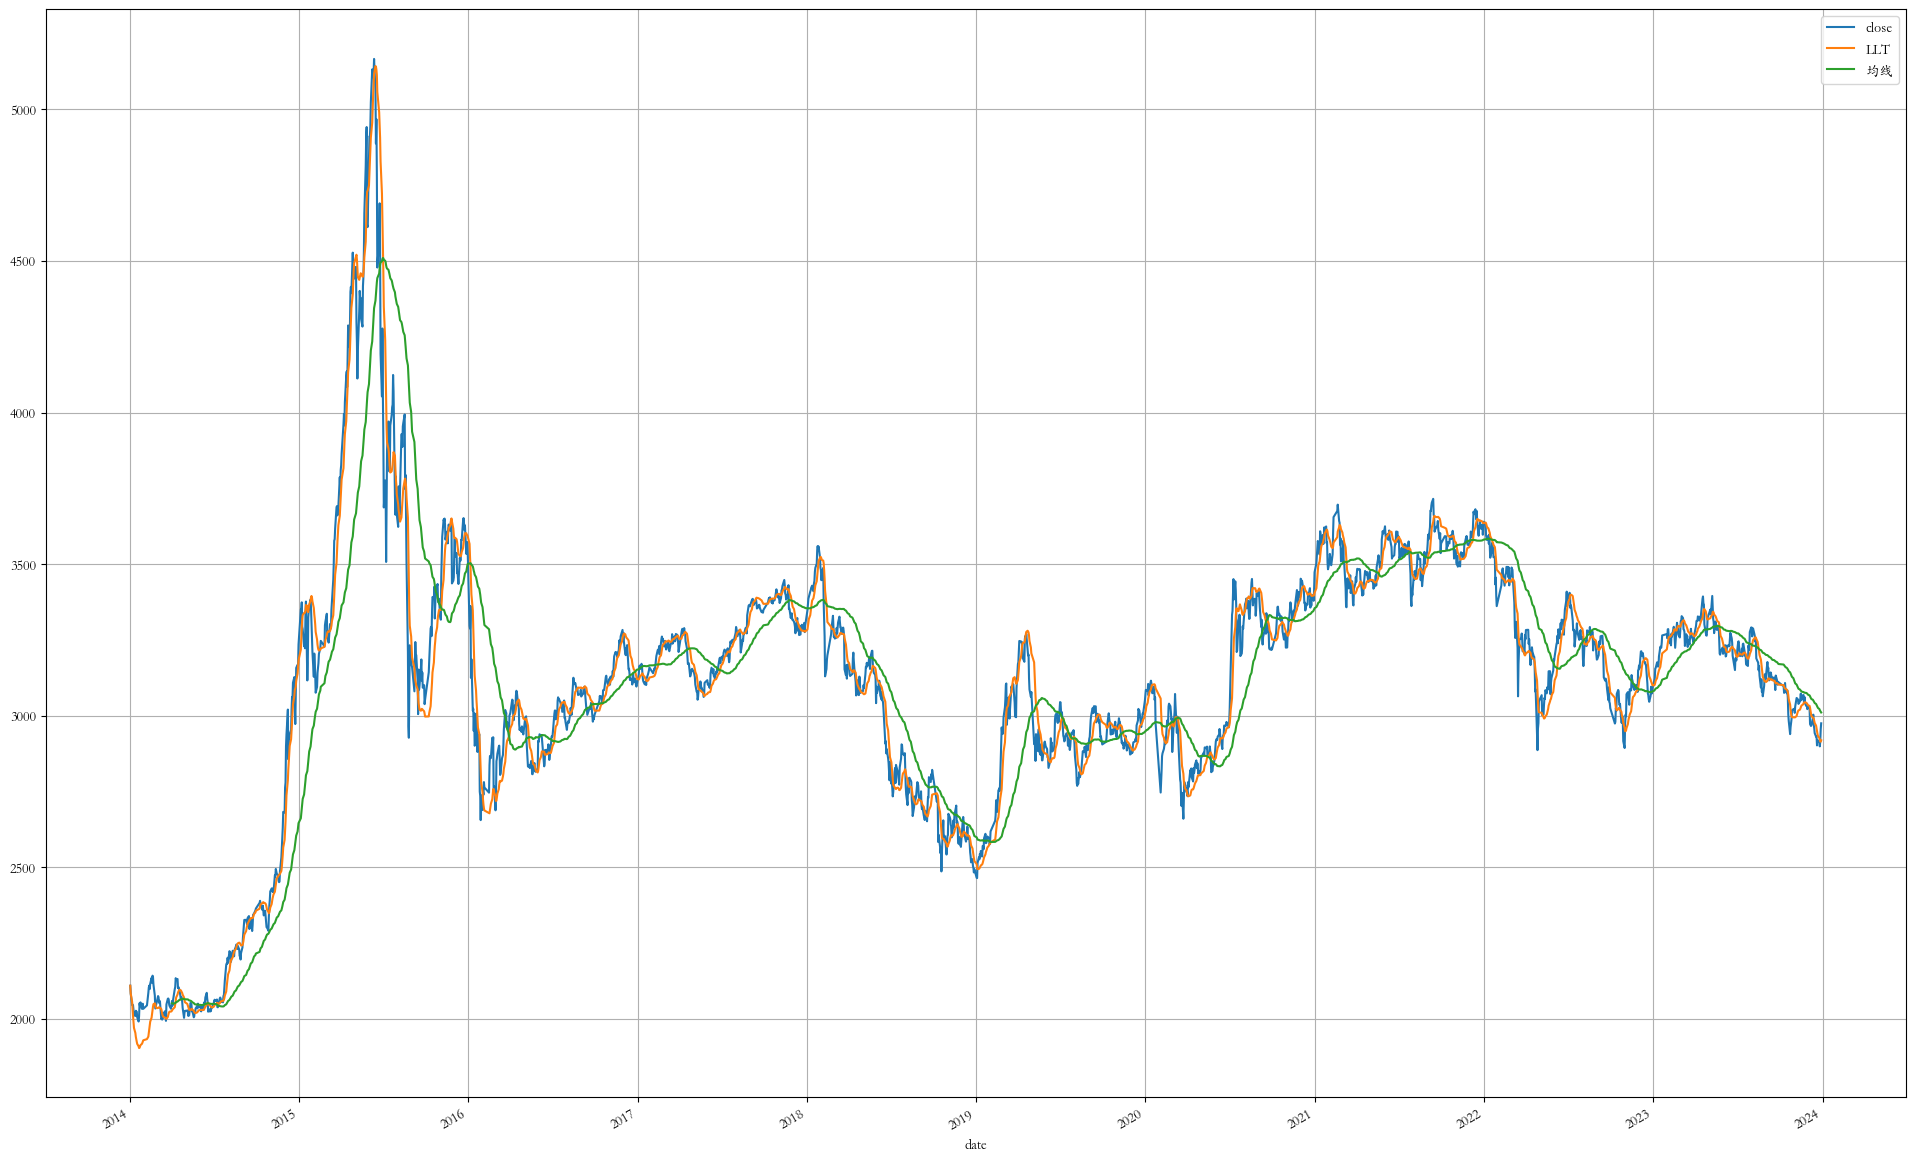

In [36]:
# 比较均线
price_df['均线'] = ta.sma(price_df['close'], length=d)
# 可视化输出
price_df[['close', 'LLT', '均线']].plot(figsize=(24, 16), grid=True)

# 择时策略

In [31]:
# 择时信号：当日 LLT 值大于昨日则开仓，否则清仓
timing_df = (price_df[['LLT']].diff() > 0) * 1.
timing_df['不择时'] = 1.

In [32]:
# 计算择时和不择时的每日收益率
timing_ret = timing_df.mul(price_df['returns'], axis=0)
# 计算累计收益率
cumul_ret = (1 + timing_ret.fillna(0)).cumprod() - 1.

<Axes: title={'center': 'LLT 择时'}, xlabel='date'>

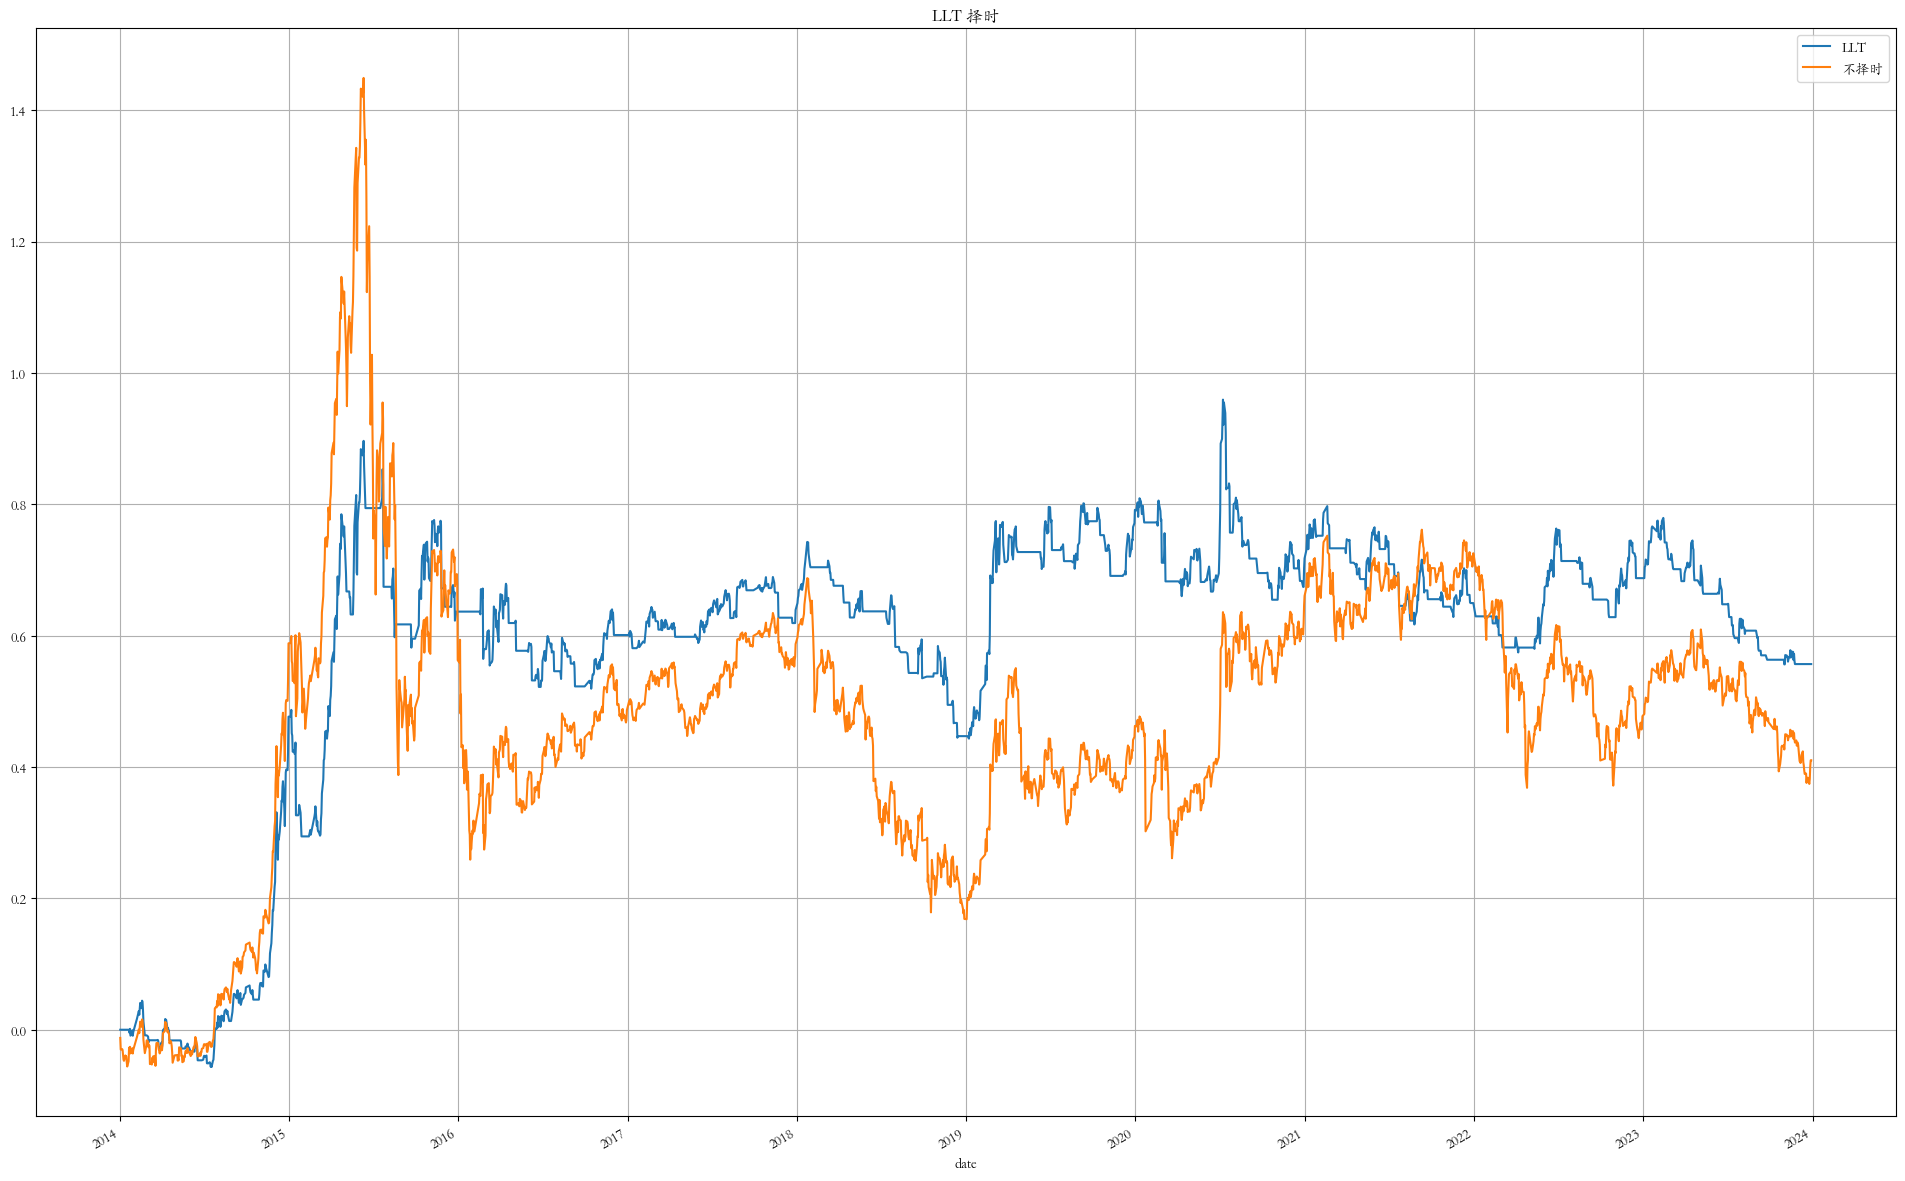

In [35]:
# 可视化输出
cumul_ret.plot(figsize=(24, 16), title='LLT 择时', grid=True)